# Data exploration

The bulk analysis is performed in `bulk_process.ipynb`. Here, we instead show a few points which help with our analysis and create one-of-a-kind figures.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import xarray as xr

from matplotlib.colors import Normalize, LogNorm
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tcvx21
from tcvx21 import Quantity, summarise_tree_dict
# Apply the custom style sheet, which makes the plots look the same
plt.style.use(tcvx21.style_sheet)

## Poloidal profiles


In [2]:
from tcvx21 import read_struct_from_file, convert_xarray_to_quantity
from tcvx21.grillix_post import components, filepath_resolver

gbs_data = read_struct_from_file(tcvx21.gbs_dir / 'simulation_data' / 'n_snap_GBS.mat')
tkx_data = read_struct_from_file(tcvx21.tokam3x_dir / 'simulation_data' / 'dataset_TK3X_10Jun21.mat')['Forw']['snapshot_poloidal']
print("Shifting TOKAM3X outward by 25cm")
tkx_data['R'] = np.copy(tkx_data['R']) + 0.25

file_path = tcvx21.grillix_dir / 'checkpoints_for_1mm' / 'reversed_field'
if not file_path.exists():
    # If the checkpoints aren't available, instead use the sample data
    file_path = tcvx21.sample_data

grid = components.Grid(file_path / 'vgrid.nc')
norm = components.Normalisation.initialise_from_normalisation_file(filepath_resolver(file_path, 'physical_parameters.nml'))
snaps = components.read_snaps_from_file(file_path, norm, all_planes=False).isel(tau=0, phi=0)
equi = components.Equi(filepath_resolver(file_path, 'TCV_ortho.nc'), filepath_resolver(file_path, 'pen_metainfo.nc'))

R0 = norm.R0.to('m').magnitude
# Select only the 'interior' data -- where the penalisation characteristic funciton is < 0.5. Then convert the xarray to a pint.Quantity, and then find the magnitude in m^-3
grillix_data = dict(
    n=convert_xarray_to_quantity(grid.shape(snaps.density.where(equi.penalisation_characteristic < 0.5))).to('1/m^3').magnitude,
    R=grid.r_s * R0,
    Z=grid.z_s * R0,
)
density_source = components.density_source_function(equi.normalised_flux_surface_label(grid.r_s, grid.z_s), grid.districts, norm, source_strength=1.0)
core_source = components.core_temperature_source_function(equi.normalised_flux_surface_label(grid.r_s, grid.z_s), grid.districts, norm, source_strength=1.0)

rho = dict(
    R=equi.spline_basis_r * R0,
    Z=equi.spline_basis_z * R0,
    rho=equi.normalised_flux_surface_label(equi.spline_basis_r, equi.spline_basis_z, grid=True)
)


Shifting TOKAM3X outward by 25cm


In [3]:
from tcvx21.plotting.plot_array_as_transparency_m import plot_array_as_transparency
from tcvx21.plotting.labels_m import label_subplots

fig, axs = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(7.5, 6))

# First, let's plot the LIUQE magnetic data
axs[0].contour(rho['R'], rho['Z'], rho['rho'], levels=20)

# Plot the sources, and bring them to in front of the flux-surfaces
im = plot_array_as_transparency(axs[0], grid.r_s * R0, grid.z_s * R0,
                                alphas=density_source, cmap=plt.cm.Greens, intensity=0.7)
im.set_zorder(np.inf)
im = plot_array_as_transparency(axs[0], grid.r_s * R0, grid.z_s * R0,
                                alphas=core_source, cmap=plt.cm.Blues, intensity=0.7)
im.set_zorder(np.inf)
axs[0].set_title('LIUQE')

cmap = 'inferno'
density_values = np.concatenate((gbs_data['n'].flatten(), grillix_data['n'].flatten(), tkx_data['N'].flatten()))
cmap_norm = LogNorm(vmin=np.nanmin(density_values), vmax=np.nanmax(density_values))

axs[1].pcolormesh(rho['R'], rho['Z'], np.ones_like(rho['rho']), vmin=0.0, vmax=2.0, cmap=plt.cm.Greys)
image = axs[1].pcolormesh(gbs_data['x'], gbs_data['y'], gbs_data['n'], norm=cmap_norm, cmap=cmap)
axs[1].set_title('GBS')

axs[2].pcolormesh(rho['R'], rho['Z'], np.ones_like(rho['rho']), vmin=0.0, vmax=2.0, cmap=plt.cm.Greys)
image = axs[2].pcolormesh(grillix_data['R'], grillix_data['Z'], grillix_data['n'], norm=cmap_norm, cmap=cmap)
axs[2].set_title('GRILLIX')

axs[3].pcolormesh(rho['R'], rho['Z'], np.ones_like(rho['rho']), vmin=0.0, vmax=2.0, cmap=plt.cm.Greys)
image = axs[3].pcolormesh(tkx_data['R'], tkx_data['Z'], tkx_data['N'], norm=cmap_norm, cmap=cmap)
axs[3].set_title('TOKAM3X')

divertor_ = tcvx21.read_from_json(tcvx21.experimental_reference_dir/'reference_scenario/divertor_polygon.json')
separatrix = tcvx21.analysis.find_contours(rho['R'], rho['Z'], rho['rho'], level=1.0)[1]

for ax in axs:
    # Mark the separatrix
    ax.plot(*separatrix.T, 'C2', label='Separatrix', linestyle='--')
    # Mark the divertor
    ax.plot(divertor_['r_points'], divertor_['z_points'], color='C0', label='Vessel', linewidth=2.0*plt.rcParams['lines.linewidth'])

    # Set the plot limits in terms of the divertor
    ax.set_xlim(divertor_['r_points'].min(), divertor_['r_points'].max())
    ax.set_ylim(divertor_['z_points'].min(), divertor_['z_points'].max())

    ax.set_aspect('equal')

cbar = plt.colorbar(image, ax=axs.flatten(), fraction=0.0295, pad=0.04)
cbar.ax.set_title(f"n [1/$m^3$]")

fig.text(0.5, 0.15, 'Radial position (R) [m]', ha='center')
axs[0].set_ylabel('Vertical position (Z) [m]')

axs[3].legend(loc='upper right')

label_subplots(axs)

tcvx21.plotting.savefig(fig, tcvx21.results_dir/'analysis_fig'/'poloidal_profiles.png')

## X-point profiles

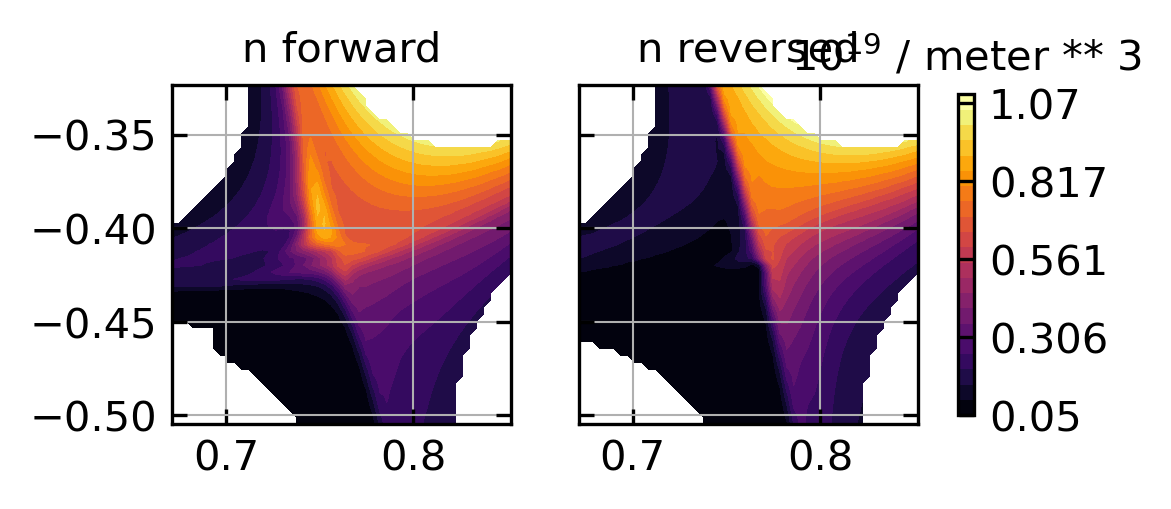

In [4]:
from tcvx21.grillix_post.components.grid_m import shape_single

def plot_xpoint_detail(forward_dataset, reversed_dataset, observable, label, offset = None, output_path=None):

    forward_data = xr.open_dataset(forward_dataset, group=f'Xpt/observables/{observable}')
    reversed_data = xr.open_dataset(reversed_dataset, group=f'Xpt/observables/{observable}')

    fwd = shape_single(forward_data['R'], forward_data['Z'], forward_data['value'])
    rev = shape_single(reversed_data['R'], reversed_data['Z'], reversed_data['value'])

    cnorm = Normalize(min(fwd.min(), rev.max()), max(fwd.max(), rev.max()))

    fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

    image = axs[0].contourf(fwd.R, fwd.Z, fwd.values, norm=cnorm, levels=20)
    axs[0].set_title(f'{label} forward')
    image = axs[1].contourf(rev.R, rev.Z, rev.values, norm=cnorm, levels=20)
    axs[1].set_title(f'{label} reversed')

    cbar = plt.colorbar(image, ax=axs, fraction=0.02)
    units_string = f"{Quantity(1, fwd.units).units}"
    if offset is not None:
        cbar.ax.set_title(f"$10^{{{np.log10(offset):n}}}${units_string.lstrip('1')}")
    else:
        cbar.ax.set_title(units_string)
        
    offset_ = offset if offset is not None else 1.0
    ticks = np.linspace(cnorm.vmin, cnorm.vmax, num=5, endpoint=True)
    tick_labels = [f'{x/ offset_:.3g}' for x in ticks]

    cbar.set_ticks(ticks)
    cbar.set_ticklabels(tick_labels)

    for ax in axs:
        ax.set_aspect('equal')

    # fig.text(0.5, 0.09, 'R [m]', ha='center')
    # fig.text(0.02, 0.5, 'Z [m]', va='center', rotation='vertical')

    if output_path is not None:
        tcvx21.plotting.savefig(fig, output_path, show=True)

plot_xpoint_detail(tcvx21.grillix_dir/'GRILLIX_forward_field.nc',
                   tcvx21.grillix_dir/'GRILLIX_reversed_field.nc',
                   'density', 'n', offset=1E19, output_path=tcvx21.results_dir/'analysis_fig'/'x_point_density.png')
plot_xpoint_detail(tcvx21.grillix_dir/'GRILLIX_forward_field.nc',
                   tcvx21.grillix_dir/'GRILLIX_reversed_field.nc',
                   'potential', '$V_{pl}$', output_path=tcvx21.results_dir/'analysis_fig'/'x_point_potential.png')
plot_xpoint_detail(tcvx21.grillix_dir/'GRILLIX_forward_field.nc',
                   tcvx21.grillix_dir/'GRILLIX_reversed_field.nc',
                   'electron_temp', '$T_e$', output_path=tcvx21.results_dir/'analysis_fig'/'x_point_electron_temp.png')

## Dependence on free-parameters

Visualising the $R(d_j)$ smooth-step function

In [5]:
from tcvx21.quant_validation.ricci_metric_m import level_of_agreement_function

fig, ax = plt.subplots()
test_distance = np.linspace(0, 5)

ax.plot(test_distance, level_of_agreement_function(test_distance, 1.0, 0.5), label="$d_0=1, \\lambda=0.5$")
ax.plot(test_distance, level_of_agreement_function(test_distance, 1.0, 1.0), label="$d_0=1, \\lambda=1$")
ax.plot(test_distance, level_of_agreement_function(test_distance, 2.0, 0.5), label="$d_0=2, \\lambda=0.5$")

ax.set_title("Level-of-agreement function")
ax.set_ylabel("$R(d_j)$")
ax.set_xlabel("Normalised distance ($d_j$)")

ax.set_ylim(0, 1)
ax.set_xlim(0, 5)

ax.legend()

tcvx21.plotting.savefig(fig, tcvx21.results_dir/'analysis_fig'/'level_of_agreement_smoothstep.png', show=True)


/Users/tbody/Documents/work/tcv-x21/tcvx21/quant_validation/ricci_metric_m.py:94: RuntimeWarning: divide by zero encountered in true_divide
  (distance - 1.0 / distance - agreement_threshold) / transition_sharpness
/Users/tbody/Documents/work/tcv-x21/tcvx21/quant_validation/ricci_metric_m.py:94: RuntimeWarning: divide by zero encountered in true_divide
  (distance - 1.0 / distance - agreement_threshold) / transition_sharpness
/Users/tbody/Documents/work/tcv-x21/tcvx21/quant_validation/ricci_metric_m.py:94: RuntimeWarning: divide by zero encountered in true_divide
  (distance - 1.0 / distance - agreement_threshold) / transition_sharpness


## Load in the validation analysis

(Identical to `bulk_process.ipynb`)

## Data loading

The data is stored in NetCDF files in the `data` folder. The structure of the data files is set by the template file `observables.json`, which allows us to use the same methods for all the data.

Where data is missing, we use an `EmptyRecord` to indicate that the entire comparison should be neglected, or an `EmptyObservable` to indicate that a single observable should be neglected. Both have the property `.is_empty = True`

## Limiting the $R^u_{sep}$-range of the validation

### Target Langmuir probes
The Langmuir probe diagnostic doesn't provide sensible data when the plasma becomes cold and/or
low-density, since we can't reliably fit IV curves. To exclude these points from our analysis,
we mark x-limits for the LFS and HFS Langmuir probe arrays.

We select limits where the $J_{sat}$ signal is significantly above the background, and the
signal as a function of position is reasonably smooth. These conditions are somewhat subjective,
so you can try select different limits and see how that affects the analysis.

Once we have set `limits`, we can then pass this to `get_observable` and `plot_observable` to
limit the range of data returned.

### Other diagnostics

We also crop the other measurements, despite the signal being strong enough to compare to. This is because
GRILLIX and TOKAM3X use limiting flux-surfaces, and as such don't model the far-SOL.

GBS, on the other hand, does include the far-SOL. Rather than comparing different sets of points between codes,
we instead select the range of points where all codes provide data (since otherwise the far-SOL comparison might
unfairly disadvantage GBS in case of disagreement)

We don't, however, crop the `LFS-IR` diagnostic, since the $q_\parallel$ measurements appear reasonable over the available data range, and including the full range helps to determine the $q_\parallel$ background

## Limiting the $Z_X$-range of the validation

We also want to remove the data very close to the target in the RDPA, because we are combining
in $Z-Z_X$ coordinates. This means that vertical translation of the plasma will cause
shifting of the wall in the coordinates we are using. Close to the wall, we expect
strong gradients due to the sheath, so combining vertically-translated shots might lead
to combining data which is not comparable. To avoid this, we simply crop our comparison

## Important note

The crop limits are not global. You can experiment here to set them to different levels, but they won't affect the bulk analysis unless you copy the values to that notebook.

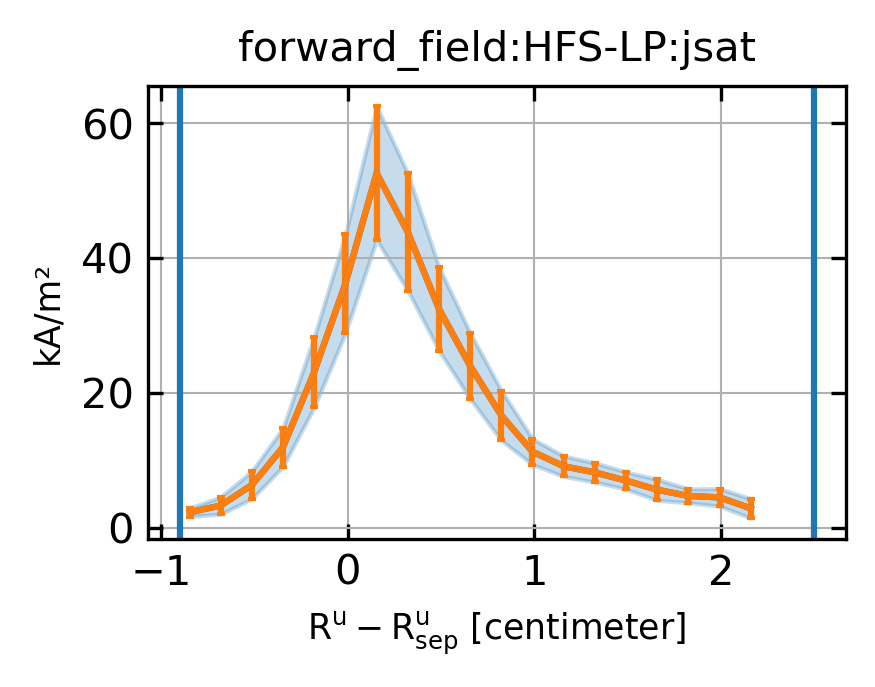

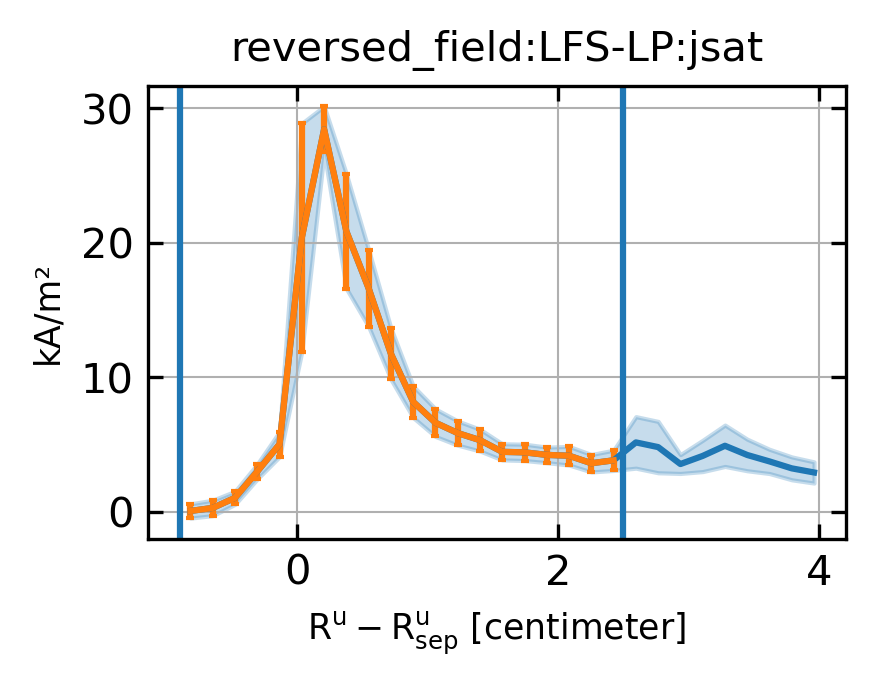

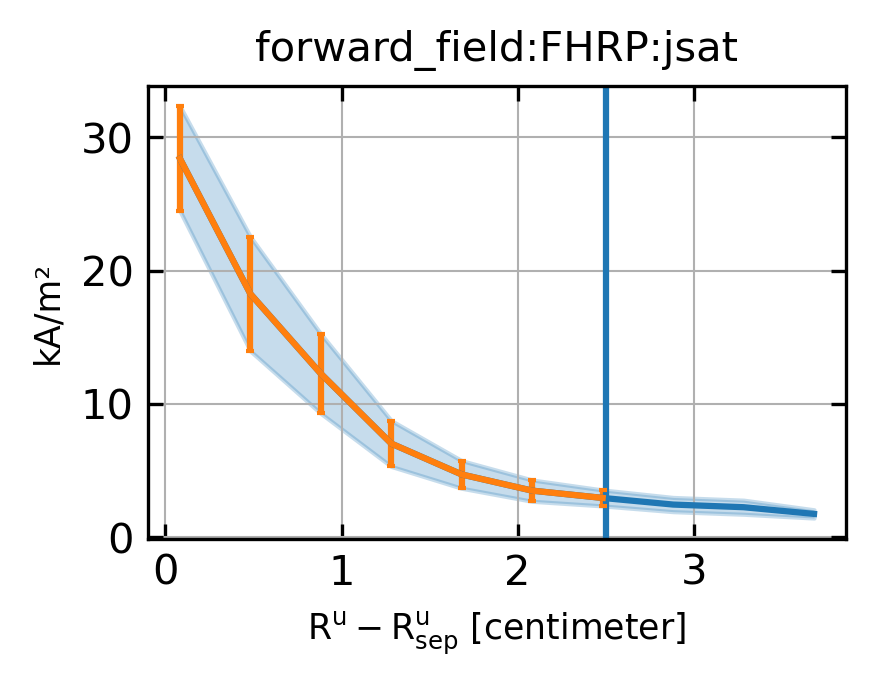

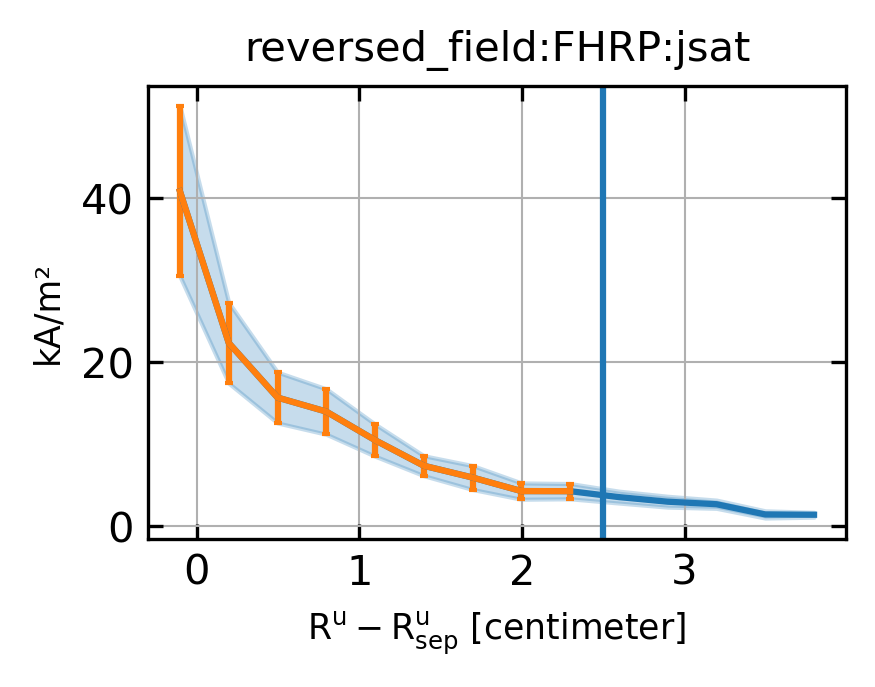

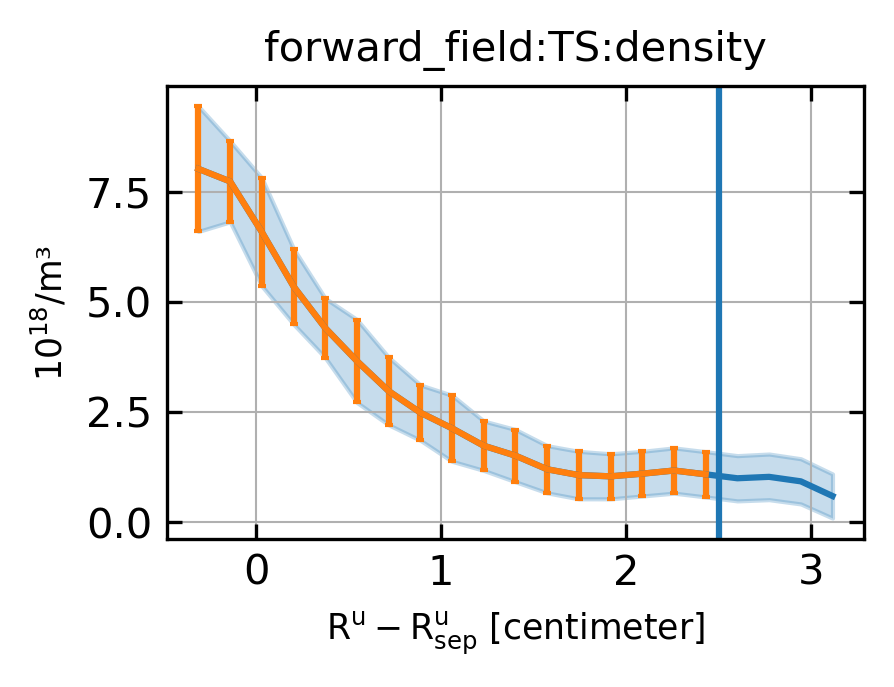

In [6]:
from tcvx21 import Record, EmptyRecord

# Experiment reference data
experimental_data = dict(
    forward_field=Record(tcvx21.experimental_reference_dir / 'TCV_forward_field.nc', color='C0'),
    reversed_field=Record(tcvx21.experimental_reference_dir / 'TCV_reversed_field.nc', color='C0')
)

simulation_data = dict(
    GBS=dict(
        forward_field= Record(tcvx21.gbs_dir / 'GBS_forward_field.nc', color='C2', linestyle='dashed'),
        reversed_field= Record(tcvx21.gbs_dir / 'GBS_reversed_field.nc', color='C2', linestyle='dashed'),
    ),
    GRILLIX=dict(
        forward_field= Record(tcvx21.grillix_dir / 'GRILLIX_forward_field.nc', color='C1', label='GRILLIX', linestyle='dotted'),
        reversed_field= Record(tcvx21.grillix_dir / 'GRILLIX_reversed_field.nc', color='C1', label='GRILLIX', linestyle='dotted'),
    ),
    TOKAM3X=dict(
        forward_field= Record(tcvx21.tokam3x_dir / 'TOKAM3X_forward_field.nc', color='C3', label='TOKAM3X', linestyle='dashdot'),
        reversed_field= EmptyRecord()
    )
)

# Set the error to zero for all simulations (i.e. drop the bootstrapping error from GRILLIX)
for code_results in simulation_data.values():
    for field_direction_results in code_results.values():
        if not field_direction_results.is_empty:
            field_direction_results.set_error_to_zero()

def set_limits_from_observable(field_direction, diagnostic, observable_key='jsat',
                               position_min=Quantity(-np.inf, 'cm'), position_max=Quantity(np.inf, 'cm'),
                               plot: bool=False):

    if plot: _, ax = plt.subplots(figsize=(3,2))
    observable = experimental_data[field_direction].get_observable(diagnostic, observable_key)
    # Reset the mask to plot full range
    observable.set_mask()

    if plot:
        observable.plot(ax)
        ax.set_title(f"{field_direction}:{diagnostic}:{observable_key}")
        ax.axvline(position_min)
        ax.axvline(position_max)

    observable.set_mask(position_min=position_min, position_max=position_max)
    if plot: plt.errorbar(observable.positions, observable.values, observable.errors, color='C1')

    for diagnostic_, observable_ in experimental_data[field_direction].keys():
        if diagnostic_ == diagnostic:
            observable = experimental_data[field_direction].get_observable(diagnostic_, observable_)
            if observable.is_empty:
                continue
            observable.set_mask(position_min=position_min, position_max=position_max)

plot_cropping = True
# Set target crops
set_limits_from_observable('forward_field', 'HFS-LP', position_min=Quantity(-0.9, 'cm'), position_max=Quantity(2.5, 'cm'), plot=plot_cropping)
set_limits_from_observable('forward_field', 'LFS-LP', position_min=Quantity(-0.9, 'cm'), position_max=Quantity(2.5, 'cm'), plot=plot_cropping)
set_limits_from_observable('reversed_field', 'HFS-LP', position_min=Quantity(-0.9, 'cm'), position_max=Quantity(2.5, 'cm'), plot=plot_cropping)
set_limits_from_observable('reversed_field', 'LFS-LP', position_min=Quantity(-0.9, 'cm'), position_max=Quantity(2.5, 'cm'), plot=plot_cropping)

set_limits_from_observable('forward_field', 'FHRP', position_max=Quantity(2.5, 'cm'), plot=plot_cropping)
set_limits_from_observable('reversed_field', 'FHRP', position_max=Quantity(2.5, 'cm'), plot=plot_cropping)
set_limits_from_observable('forward_field', 'TS', 'density', position_max=Quantity(2.5, 'cm'), plot=plot_cropping)
set_limits_from_observable('reversed_field', 'TS', 'density', position_max=Quantity(2.5, 'cm'), plot=plot_cropping)

# Crop the RDPA
for expt in experimental_data.values():
    for diagnostic, observable in expt.keys():
        if not diagnostic == 'RDPA': continue
        m = expt.get_observable(diagnostic, observable)
        if not m.is_empty: m.set_mask(zx_min=Quantity(-0.32, 'm'))

## Testing the parameter dependence

The $\chi$ value has two terms, $d_0$ and $\lambda$, which set the agreement
threshold and transition sharpness respectively.

We can see the effect of these terms by testing how they impact $\chi$ for a
real validation.

We see that $d_0$ has a strong impact on the resulting $\chi$ value, while
$\lambda$ has a weaker effect. Therefore, we keep $\lambda = 0.5$.

/Users/tbody/Documents/work/tcv-x21/tcvx21/quant_validation/ricci_metric_m.py:94: RuntimeWarning: divide by zero encountered in double_scalars
  (distance - 1.0 / distance - agreement_threshold) / transition_sharpness


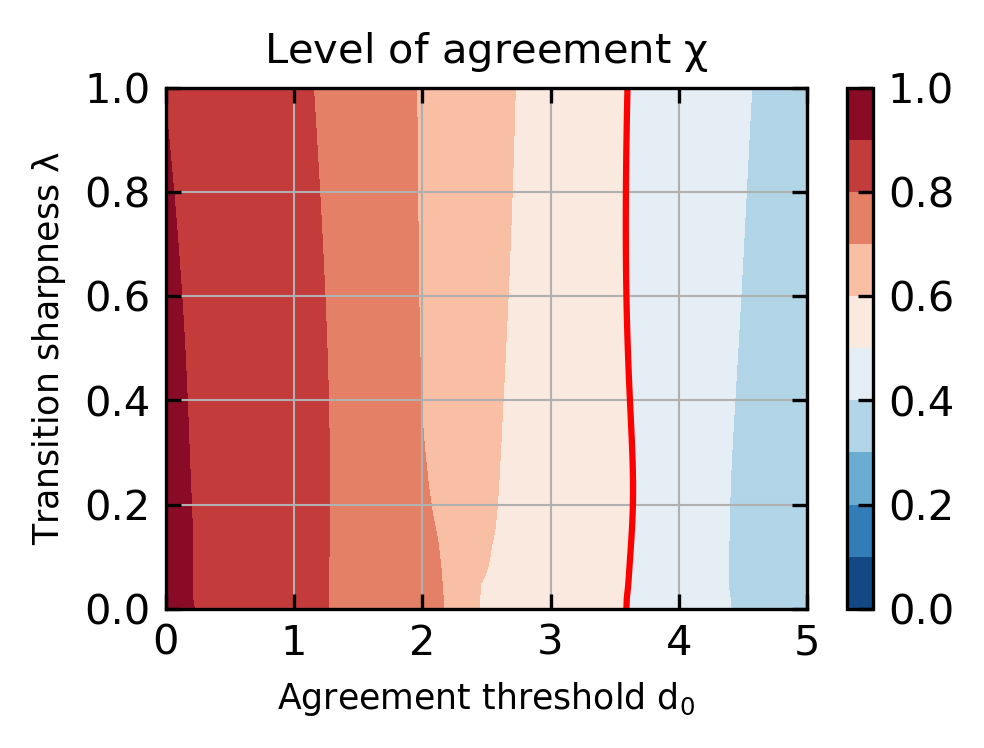

In [7]:
from tcvx21.quant_validation.ricci_metric_m import RicciValidation

validation = RicciValidation(experimental_data['forward_field'], simulation_data['GRILLIX']['forward_field'])
validation.calculate_metric_terms()

agreement_threshold = np.linspace(0, 5, num=60)
transition_sharpness = np.linspace(0, 1.0, num=50)

chi = np.ones((transition_sharpness.size, agreement_threshold.size))
Q = np.ones((transition_sharpness.size, agreement_threshold.size))

for i, d0 in enumerate(agreement_threshold):
    for j, lambda_ in enumerate(transition_sharpness):

        chi[j][i], Q[j][i] = validation.compute_chi(agreement_threshold=d0, transition_sharpness=lambda_)

fig, ax = plt.subplots()

mappable = ax.contourf(agreement_threshold, transition_sharpness, chi, levels=np.linspace(0, 1, num=11), cmap='RdBu_r')
plt.colorbar(mappable, ax=ax)
ax.contour(agreement_threshold, transition_sharpness, chi, levels=[0.5], colors='r')

ax.set_xlabel('Agreement threshold $d_0$')
ax.set_ylabel('Transition sharpness $\lambda$')
ax.set_title('Level of agreement $\chi$')

tcvx21.plotting.savefig(fig, tcvx21.results_dir/'analysis_fig'/'chi_dependence_on_parameters.png', show=True)

We can frame our validation in two ways. One is, given a particular $d_0$ agreement threshold,
what is our level of agreement. Another is, given a particular desired level of
agreement, what is the agreement threshold which would allow us to achieve that
level of agreement.

This is best represented in a $\chi(d_0)$ graph.

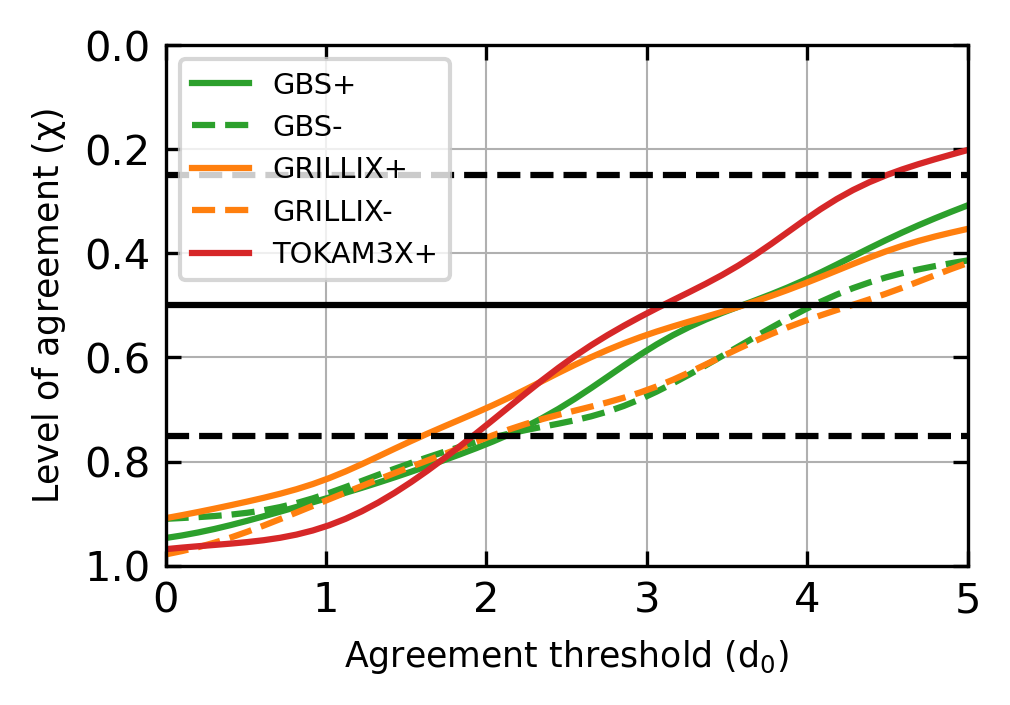

In [8]:
validation_cases = {
    'GBS+': RicciValidation(experimental_data['forward_field'], simulation_data['GBS']['forward_field']),
    'GBS-': RicciValidation(experimental_data['reversed_field'], simulation_data['GBS']['reversed_field']),
    'GRILLIX+': RicciValidation(experimental_data['forward_field'], simulation_data['GRILLIX']['forward_field']),
    'GRILLIX-': RicciValidation(experimental_data['reversed_field'], simulation_data['GRILLIX']['reversed_field']),
    'TOKAM3X+': RicciValidation(experimental_data['forward_field'], simulation_data['TOKAM3X']['forward_field']),
}

fig, ax = plt.subplots()
agreement_threshold = np.linspace(0, 5, num=50)

for key, case in validation_cases.items():

    case.calculate_metric_terms()

    chi, Q = np.ones_like(agreement_threshold), np.ones_like(agreement_threshold)

    for i, d0 in enumerate(agreement_threshold):
        chi[i], Q[i] = case.compute_chi(agreement_threshold=d0, transition_sharpness=0.5)

    linestyle = '-' if '+' in key else '--'
    linecolor = case.simulation.color
    ax.plot(agreement_threshold, chi, label=key, linestyle=linestyle, color=linecolor)

ax.set_xlabel('Agreement threshold ($d_0$)')
ax.set_ylabel('Level of agreement ($\chi$)')

ax.axhline(0.5, color='k')
ax.axhline(0.25, color='k', linestyle='--')
ax.axhline(0.75, color='k', linestyle='--')
ax.set_xlim(agreement_threshold.min(), agreement_threshold.max())
ax.set_ylim(bottom=0.0, top=1.0)
ax.invert_yaxis()
plt.legend()

tcvx21.plotting.savefig(fig, tcvx21.results_dir/'analysis_fig'/'chi_for_various_agreement_thresholds.png', show=True)

# Units calculator

We can also use `tcvx21` as a units calculator. This is particularly helpful for seeing checking how the resistivity and heat conductivities relate to the experimental values. Note that these formulas come from the Braginskii 1965 book chapter and the NRL Plasma formulary.

In [9]:
from tcvx21 import Quantity, unit_registry as ureg

elementary_charge = Quantity(1, 'elementary_charge')
electron_mass = Quantity(1, 'electron_mass')
proton_mass = Quantity(1, 'proton_mass')
atomic_mass_units = Quantity(1, 'amu')
speed_of_light = Quantity(1, 'speed_of_light')
vacuum_permeability = Quantity(1, 'mu0')
vacuum_permittivity = Quantity(1, 'vacuum_permittivity')


@ureg.wraps(ret="", args=['cm**-3', 'eV'], strict=True)
def Coulomb_logarithm_ee(n, Te):
    """
    Coulomb logarithm (unitless) for thermal electron-electron collisions

    You can pass n and Te in any units, and these will be converted to
    cgs+eV such that the following formula applies
    """
    if Te > 10:
        return 24. - np.log(np.sqrt(n) / Te)
    else:
        return 23. - np.log(np.sqrt(n) / Te**(1.5))


def tau_ee(n, Te, Z):
    """
    Electron-electron collision time

    This is the mean time required for the direction of motion of an individual electron
    to be deflected by approximately 90 degrees due to collisions with electrons
    """
    lnLambda = Coulomb_logarithm_ee(n, Te)

    return ((6. * np.sqrt(2.) * np.pi**1.5 * vacuum_permittivity**2 * np.sqrt(electron_mass) * Te**1.5)/
            (lnLambda * elementary_charge**4 * Z * n)
    ).to('s')


def tau_ii(n, Te, Ti, Mi, Z):
    """
    Ion-ion collision time

    This is the mean time required for the direction of motion of an individual ion
    to be deflected by approximately 90 degrees due to collisions with ions
    """
    lnLambda = Coulomb_logarithm_ee(n, Te)

    return ((12. * np.pi**1.5 * vacuum_permittivity**2 * np.sqrt(Mi) * Ti**1.5)/
            (lnLambda * elementary_charge**4 * Z**3 * n)
    ).to('s')

def spitzer_resistivity(n, Te, Z=Quantity(1, 'e')):
    
    return (0.51 * Quantity(1, 'electron_mass') / (Quantity(1, 'elementary_charge')**2 * n * tau_ee(n, Te, Z))
           ).to('microohm*meter')

def braginskii_electron_heat_conductivity(n, Te, Z=1):
    
    return (3.16 * n * Te * tau_ee(n, Te, Z) / Quantity(1, 'electron_mass')
           ).to('MW / eV * meter^-1')

def braginskii_ion_heat_conductivity(n, Te, Ti, Z=1, Mi=Quantity(2, 'proton_mass')):
    
    return (3.9 * n * Ti * tau_ii(n, Te, Ti, Mi, Z) / Mi
           ).to('MW / eV * meter^-1')


def calculate_params(n, Te, Ti = None, Z=1, resistivity_factor=1, conductivity_factor=1):
    
    if Ti is None:
        Ti = Te
    
    resistivity = spitzer_resistivity(n, Te, Z) * resistivity_factor
    chipar_e = braginskii_electron_heat_conductivity(n, Te, Z) * conductivity_factor
    chipar_i = braginskii_ion_heat_conductivity(n, Te, Ti, Z) * conductivity_factor
    
    return resistivity, chipar_e, chipar_i

calculate_params(Quantity(6E18, 'm^-3'), Quantity(40, 'eV'))

(2.698249104512621 <Unit('meter * microohm')>,
 23.89104841809778 <Unit('megawatt / electron_volt / meter')>,
 0.6881107429195307 <Unit('megawatt / electron_volt / meter')>)